## Library


In [1]:
import copy
import datetime as dt
import linearmodels as lm
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import signal


### Supporting functions


In [2]:
def halfHour(time: dt.time) -> str:
    if dt.time(9, 30) <= time <= dt.time(9, 59):
        return "09H2"
    elif dt.time(10, 00) <= time <= dt.time(10, 29):
        return "10H1"
    elif dt.time(10, 30) <= time <= dt.time(10, 59):
        return "10H2"
    elif dt.time(11, 00) <= time <= dt.time(11, 29):
        return "11H1"
    elif dt.time(11, 30) <= time <= dt.time(12, 5):
        return "11H2"
    elif dt.time(13, 00) <= time <= dt.time(13, 29):
        return "13H1"
    elif dt.time(13, 30) <= time <= dt.time(13, 59):
        return "13H2"
    elif dt.time(14, 00) <= time <= dt.time(14, 29):
        return "14H1"
    elif dt.time(14, 30) <= time <= dt.time(14, 59):
        return "14H2"
    elif dt.time(15, 00) <= time <= dt.time(15, 29):
        return "15H1"
    elif dt.time(15, 30) <= time <= dt.time(15, 59):
        return "15H2"
    else:
        return "Err"


In [3]:
def readIntraday(path: str, sheet: str) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=sheet, parse_dates=[0])
    df.set_index([df.index, df["Datetime"]], inplace=True)
    df.drop(["Datetime"], axis=1, inplace=True)
    df["Date"] = [day[1].date() for day in df.index]
    df["Time"] = [day[1].time() for day in df.index]
    df["HHV"] = [halfHour(i) for i in df["Time"]]
    return df


In [4]:
def readInterday(path: str, sheet: str) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=sheet, parse_dates=[0]).iloc[:, :2]
    df.set_index([df.index, "Date"], inplace=True)
    df.interpolate(method="linear", limit_direction="forward", axis=0, inplace=True)
    df["YRV"] = [f"Y{day[1].date().year}" for day in df.index]
    df["MOV"] = [f"M{day[1].date().month}" for day in df.index]
    df["WDV"] = [f"D{day[1].date().weekday() + 1}" for day in df.index]
    return df


In [5]:
def detrendByAll(source: pd.DataFrame, colName: str, scope: str) -> pd.DataFrame:
    clone = copy.deepcopy(source)
    clone[colName] = signal.detrend(source[scope])
    return clone


In [6]:
def detrendByTag(source: pd.DataFrame, colName: str, scope: str, tags: str | list[str]) -> pd.DataFrame:
    dfs = [x for _, x in source.groupby(tags)]
    for df in dfs:
        df[colName] = signal.detrend(df[scope])
    return pd.concat(dfs)


In [7]:
def getOLSModel(df: pd.DataFrame, DV: str, exog_vars: str | list) -> lm.PooledOLS:
    exog = sm.add_constant(df[exog_vars])
    model = lm.PooledOLS(df[DV], exog)
    return model


In [8]:
def getS2BRatio(buy: str, sell: str, df: pd.DataFrame, yVar: str, scope: str) -> float:
    bestBuy = df[df[yVar] == buy][scope].mean()
    bestSell = df[df[yVar] == sell][scope].mean()
    b2sRatio = bestSell / bestBuy
    return b2sRatio


In [9]:
path = "./Ex4_data1.xlsx"

intraday = readIntraday(path, "Intraday_data")
intraday = detrendByAll(intraday, "DetrendAll", "HSI_Price")
intraday = detrendByTag(intraday, "DetrendDate", "HSI_Price", "Date")

interday = readInterday(path, "Interday_data")
interday = detrendByAll(interday, "DetrendAll", "Price")
interday = detrendByTag(interday, "DetrendYear", "Price", "YRV")
interday = detrendByTag(interday, "DetrendMonth", "Price", ["YRV", "MOV"])


## Intraday


### Price plot


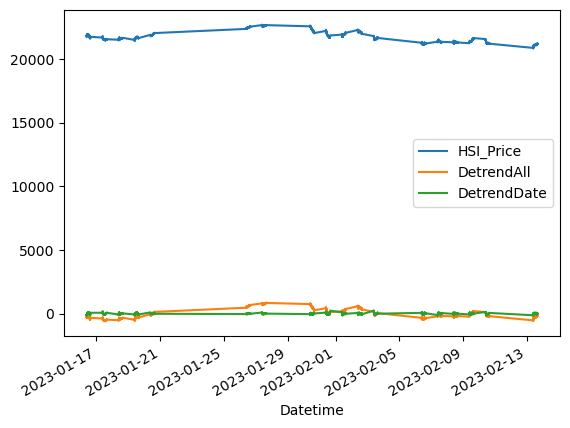

In [10]:
intraday[["HSI_Price", "DetrendAll", "DetrendDate"]].droplevel(level=0).plot()
plt.legend()


### Detrend by All Data


In [11]:
modelFit = getOLSModel(intraday, "DetrendAll", "HHV").fit()
modelFit


Dep. Variable:,DetrendAll,R-squared:,0.0003
Estimator:,PooledOLS,R-squared (Between):,0.0003
No. Observations:,6035,R-squared (Within):,0.0000
Date:,"Wed, Mar 08 2023",R-squared (Overall):,0.0003
Time:,00:39:50,Log-likelihood,-4.434e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.1969
Entities:,6035,P-value,0.9966
Avg Obs:,1.0000,Distribution:,"F(10,6024)"
Min Obs:,1.0000,,
Max Obs:,1.0000,F-statistic (robust):,0.1969


In [12]:
bestBuyTime = "13H1"
bestSellTime = "15H2"
getS2BRatio(bestBuyTime, bestSellTime, intraday, "HHV", "HSI_Price")


1.0003645369836294

### Detrend by Day


In [13]:
modelFit = getOLSModel(intraday, "DetrendDate", "HHV").fit()
modelFit


Dep. Variable:,DetrendDate,R-squared:,0.0186
Estimator:,PooledOLS,R-squared (Between):,0.0186
No. Observations:,6035,R-squared (Within):,0.0000
Date:,"Wed, Mar 08 2023",R-squared (Overall):,0.0186
Time:,00:39:51,Log-likelihood,-3.208e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,11.407
Entities:,6035,P-value,0.0000
Avg Obs:,1.0000,Distribution:,"F(10,6024)"
Min Obs:,1.0000,,
Max Obs:,1.0000,F-statistic (robust):,11.407


In [14]:
bestBuyTime = "13H1"
bestSellTime = "15H2"
getS2BRatio(bestBuyTime, bestSellTime, intraday, "HHV", "HSI_Price")


1.0003645369836294

## Interday


### Price plot


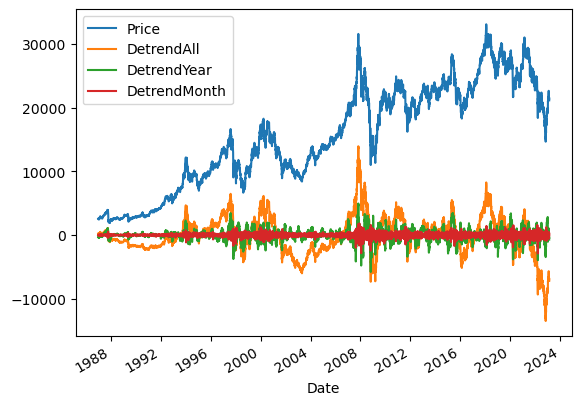

In [15]:
interday[["Price", "DetrendAll", "DetrendYear", "DetrendMonth"]].droplevel(level=0).plot()
plt.legend()


### Month and weekday as IV


In [16]:
modelFit = getOLSModel(interday, "DetrendAll", ["WDV", "MOV"]).fit()
modelFit


Dep. Variable:,DetrendAll,R-squared:,0.0028
Estimator:,PooledOLS,R-squared (Between):,0.0028
No. Observations:,9167,R-squared (Within):,0.0000
Date:,"Wed, Mar 08 2023",R-squared (Overall):,0.0028
Time:,00:39:51,Log-likelihood,-8.637e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.6035
Entities:,9167,P-value,0.0593
Avg Obs:,1.0000,Distribution:,"F(16,9150)"
Min Obs:,1.0000,,
Max Obs:,1.0000,F-statistic (robust):,1.6035


#### Daily


In [17]:
bestBuyTime = "D5"
bestSellTime = "D2"
getS2BRatio(bestBuyTime, bestSellTime, interday, "WDV", "Price")


1.000333512737961

#### Monthly


In [18]:
bestBuyTime = "M10"
bestSellTime = "M2"
getS2BRatio(bestBuyTime, bestSellTime, interday, "MOV", "Price")


1.0109782260286664

### Month and weekday as IV with data detrent by year


In [19]:
modelFit = getOLSModel(interday, "DetrendYear", ["WDV", "MOV"]).fit()
modelFit


Dep. Variable:,DetrendYear,R-squared:,0.0108
Estimator:,PooledOLS,R-squared (Between):,0.0108
No. Observations:,9167,R-squared (Within):,0.0000
Date:,"Wed, Mar 08 2023",R-squared (Overall):,0.0108
Time:,00:39:51,Log-likelihood,-7.579e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,6.2422
Entities:,9167,P-value,0.0000
Avg Obs:,1.0000,Distribution:,"F(16,9150)"
Min Obs:,1.0000,,
Max Obs:,1.0000,F-statistic (robust):,6.2422


#### Daily


In [20]:
bestBuyTime = "D1"
bestSellTime = "D5"
getS2BRatio(bestBuyTime, bestSellTime, interday, "WDV", "Price")


1.0071564046006214

#### Monthly


In [21]:
bestBuyTime = "M3"
bestSellTime = "M12"
getS2BRatio(bestBuyTime, bestSellTime, interday, "MOV", "Price")


1.0178200586860813